## Solving the multi-arm bandit

Let’s say you’re at a casino, and in front of you are 10 slot machines with a flashy
sign that says “Play for free! Max payout is $10!” Wow, not bad! Intrigued, you ask one
of the employees what’s going on, because it seems too good to be true, and she says,
“It’s really true, play as much as you want, it’s free. Each slot machine is guaranteed to
give you a reward between $0 and $10. Oh, by the way, keep this to yourself, but those
10 slot machines each have a different average payout, so try to figure out which one
gives the most rewards on average, and you’ll be making tons of cash!”

### Greedy epsilon Strategy

- We do a exploitation (choose best machine) and exploration (choose random machine) of slot machines
- choose a parameter (epsilon) that can control between the two approaches.
- Get average of each slot machine output. We take a fixed random number (probability) for each machine and add one dollar each time a random number comes greater than the probability. 
- For each arm (action): set up a for loop going to 10 (max reward), and at each step it will add 1 to the reward if a
random float is less than the arm’s probability. RUnning this for many iterations will give the value (prob*max_reward).

In [3]:
import numpy as np

# Number of slot machines/arms
N = 10

# probability for each arm 
prob_a = np.random.rand(N)


# get reward for an arm with given probability
def get_reward(prob, max_reward=10):
    reward = 0
    for _ in range(max_reward):
        if np.random.random() < prob:
            reward += 1
    return reward



# function to update the reward for an action (a) of chosing an arm at each iteration
def update_reward(record,a,reward):
    
    # update the mean and count of the arm a
    new_mean = (record[a][1]*record[a][0]+reward)/(record[a][0]+1)
    record[a][0] += 1
    record[a][1] = new_mean
    
    return record


# function to choose an arm to pull at each iteration
def choose_arm(record,epsilon):
    # choose a random number between 0 and 1
    rand = np.random.rand()
    
    # if the random number is less than epsilon, choose a random arm
    if rand < epsilon:
        return np.random.randint(N)
    
    # else, choose the arm with the highest mean reward
    else:
        return np.argmax(record[:,1],axis=0)
    

(0.0, 10.0)

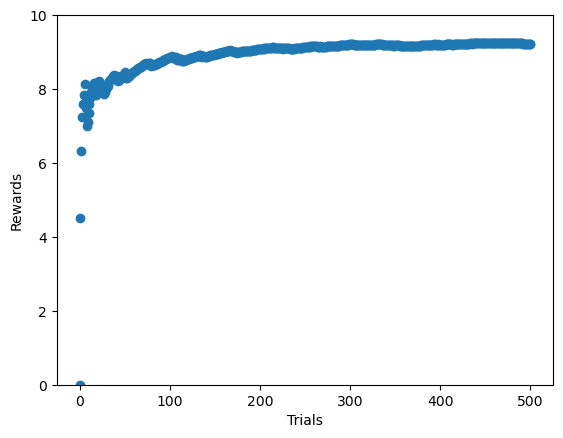

In [4]:
import matplotlib.pyplot as plt

# number of iterations
iterations = 500

# epsilon for exploration
epsilon = 0.2

# record array with shape (N,2) 
# col1: the number of times each arm has been pulled 
# col2: the total reward for each arm
record = np.zeros((N,2))


fig,ax = plt.subplots(1,1)
ax.set_xlabel(r'Trials')
ax.set_ylabel(r'Rewards')

rewards=[0]
# loop over iterations
for i in range(iterations):
    # choose an arm to pull
    a = choose_arm(record,epsilon)
    # get the reward for the chosen arm
    reward_i = get_reward(prob_a[a])
    # update the reward for the chosen arm
    record = update_reward(record,a,reward_i)
    mean_reward = ((i+1) * rewards[-1] + reward_i)/(i+2)
    rewards.append(mean_reward)

ax.scatter(np.arange(len(rewards)),rewards)
ax.set_ylim(0,10)

### Softmax selection

A newly minted doctor specializes in treating
patients with heart attacks. She has 10 treatment options, of which she can choose
only 1 to treat each patient she sees. For some reason, all she knows is that these 10
treatments have different efficacies and risk profiles for treating heart attacks—she
doesn’t know which one is the best yet. We could use the n-armed bandit algorithm
from the previous solution, but we might want to reconsider our ε-greedy policy of
randomly choosing a treatment once in a while. In this new problem, randomly choosing
a treatment could result in patient death, not just losing some money. We really
want to make sure we don’t choose the worst treatment, but we still want some ability
to explore our options to find the best one.

In [8]:
def softmax(av, tau=1.12):
    """
    Function for softmax
    Input:
        av: action value vector
        tau: temperature
    Output:
        softm: Probability vector for each action
    """
    softm = np.exp(av / tau) / np.sum( np.exp(av / tau) )
    return softm


The np.random.choice function in NumPy is used to generate a random sample from a given 1-D array. It allows you to randomly select elements, either with or without replacement, from the specified array or sequence

(0.0, 10.0)

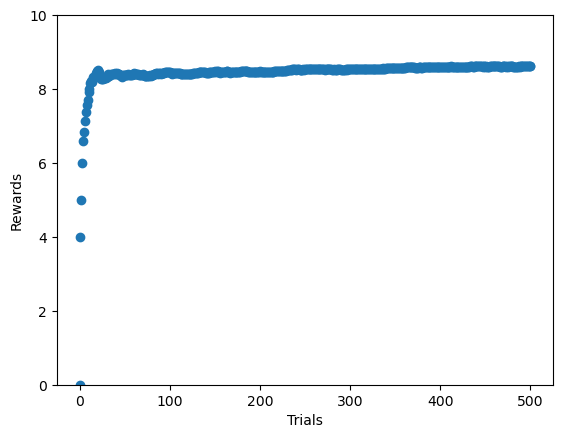

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# number of iterations
iterations = 500

# temperature for softmax
tau = 0.2

# record array with shape (N,2) 
# col1: the number of times each arm has been pulled 
# col2: the total reward for each arm
record = np.random.rand(N,2)


fig,ax = plt.subplots(1,1)
ax.set_xlabel(r'Trials')
ax.set_ylabel(r'Rewards')

rewards=[0]
# loop over iterations
for i in range(iterations):
    # choose an arm to pull
    a = np.random.choice(np.arange(N),p=softmax(record[:,1],tau))
    # get the reward for the chosen arm
    reward_i = get_reward(prob_a[a])
    # update the reward for the chosen arm
    record = update_reward(record,a,reward_i)
    mean_reward = ((i+1) * rewards[-1] + reward_i)/(i+2)
    rewards.append(mean_reward)

ax.scatter(np.arange(len(rewards)),rewards)
ax.set_ylim(0,10)

for softmax the rewards converge faster

## Contextual bandit

Let’s say we manage 10 e-commerce websites, each focusing on selling a different
broad category of retail items such as computers, shoes, jewelry, etc. We want to
increase sales by referring customers who shop on one of our sites to another site
that they might be interested in. When a customer checks out on a particular site in
our network, we will display an advertisement to one of our other sites in hopes
they’ll go there and buy something else. Alternatively, we could place an ad for
another product on the same site. Our problem is that we don’t know which sites we
should refer users to. We could try placing random ads, but we suspect a more targeted
approach is possible.


At each play of the game
(each time a customer checks out on a particular website) we have n = 10 possible
actions we can take, corresponding to the 10 different types of advertisements we
could place. The twist is that the best ad to place may depend on which site in the network
the current customer is on. For example, a customer checking out on our jewelry
site may be more in the mood to buy a new pair of shoes to go with their new
diamond necklace than they would be to buy a new laptop. Thus our problem is to figure
out how a particular site relates to a particular advertisement.

In [2]:
class ContextBandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.init_distribution(arms)
        self.update_state()
    
    # initial distribution of states space probabilities
    def init_distribution(self, arms):
        # assuming states are equal to arms so matrix is armsxarms
        self.bandit_matrix = np.random.rand(arms, arms)

    # setting rewards for a particlar state
    def reward(self, prob):
        reward = 0
        for _ in range(self.arms):
            if np.random.random() < prob:
                reward += 1
        return reward
    
    # getting the current state
    def get_state(self):
        return self.state
    
    # updating the state
    def update_state(self):
        self.state = np.random.randint(0,self.arms)
    
    # get reward for a particular arm
    def get_reward(self,arm):
        return self.reward(self.bandit_matrix[self.get_state()][arm])
    
    # choose an arm which means putting ads on site
    def choose_arm(self, arm):
        reward = self.get_reward(arm)
        self.update_state()
        return reward
    

In [67]:
class ContextBandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.init_distribution(arms)
        self.update_state()
        
    def init_distribution(self, arms):
        # Num states = Num Arms to keep things simple
        self.bandit_matrix = np.random.rand(arms,arms)
        #each row represents a state, each column an arm
        
    def reward(self, prob):
        reward = 0
        for i in range(self.arms):
            if np.random.random() < prob:
                reward += 1
        return reward
        
    def get_state(self):
        return self.state
    
    def update_state(self):
        self.state = np.random.randint(0,self.arms)
        
    def get_reward(self,arm):
        return self.reward(self.bandit_matrix[self.get_state()][arm])
        
    def choose_arm(self, arm):
        reward = self.get_reward(arm)
        self.update_state()
        return reward

In [78]:
import numpy as np
import torch

# number of arms
arms = 10
# batch size
N= 1
# input dimension
D_in= arms
# hidden dimension
H= 200
# output dimension
D_out=arms

# model with two layers
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.ReLU(),
)

# loss function
loss_fn = torch.nn.MSELoss()

# get environment instance
env = ContextBandit(arms)

# one hot encoding
def one_hot(N, pos, val=1):
    one_hot_vec = np.zeros(N)
    one_hot_vec[pos] = val
    return one_hot_vec


In [79]:
# training function
def train(env, epochs=5000, learning_rate=1e-2):
    # initial state will be a random integer denoting a state but 
    cur_state = torch.Tensor(one_hot(arms,env.get_state()))

    # optimizer function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # reward array
    rewards = []


    # main loop of training
    for i in range(epochs):
        # get prediction for current state
        y_pred = model(cur_state)
        # pass through softmax function to get probabilities
        av_softmax = softmax(y_pred.data.numpy(), tau=2.0)
        # normalize
        av_softmax /= av_softmax.sum()
        # choose an arm
        choice = np.random.choice(arms, p=av_softmax)
        # get reward for choosing an arm
        cur_reward = env.choose_arm(choice)
        # one hot encoding for reward for setting reward only for that arm
        one_hot_reward = y_pred.data.numpy().copy()
        one_hot_reward[choice] = cur_reward
        reward = torch.Tensor(one_hot_reward)

        # append reward
        rewards.append(cur_reward)
        # get loss
        loss = loss_fn(y_pred, reward)
        # update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # set current state to new state
        cur_state = torch.Tensor(one_hot(arms,env.get_state()))

    # at the end return rewards    
    return np.array(rewards)



(5000,)


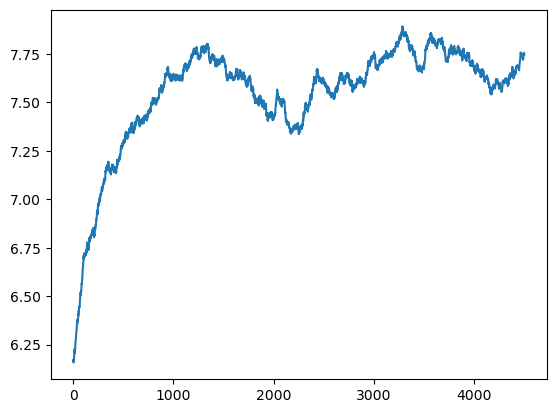

In [80]:
import numpy as np
import matplotlib.pyplot as plt

def running_mean(x,N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N
    return y


rewards2 = train(env)
print(rewards2.shape)
plt.plot(running_mean(rewards2,N=500))